In [ ]:
# default_exp unet

# Deepflash2

> API details.

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from functools import partial

In [ ]:
#export
class Unet2D:

    def __init__(self, n_channels=1, n_classes=2, n_levels=4,
               n_features=64, n_batch_norm_levels=0, upsample = False,
               relu_alpha=0.1, k_init="he_normal"):
    
        self.n_channels = n_channels
        self.n_levels = n_levels
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_batch_norm_levels = n_batch_norm_levels
        self.relu_alpha = relu_alpha
        self.k_init = k_init
        self.upsample = upsample

        self.model = self._createModel()

   
    def _createModel(self):     
        
        conf2d = partial(layers.Conv2D, padding="valid", kernel_initializer=self.k_init)
        conf2dT = partial(layers.Conv2DTranspose, padding="valid", kernel_initializer=self.k_init)
        
        data = layers.Input(shape=(None, None, self.n_channels), name="data")               

        down_stack = []
        # Modules of the analysis path consist of two convolutions and max pooling
        for l in range(self.n_levels):
            x = conf2d(2**l * self.n_features, 3, name="conv_d{}a-b".format(l))(data if l == 0 else x)
            if l > self.n_batch_norm_levels: 
                x = layers.BatchNormalization(axis=-1)(x)
            x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
            x = conf2d(2**l * self.n_features, 3, name="conv_d{}b-c".format(l))(x)
            if l > self.n_batch_norm_levels: 
                x = layers.BatchNormalization(axis=-1)(x)               
            x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
            if l >= 2: 
                x = layers.Dropout(0.5)(x)
            down_stack.append(x)
            x = layers.MaxPooling2D(pool_size=(2, 2))(x)

        # Deepest layer has two convolutions only
        x = conf2d(2**self.n_levels * self.n_features, 3, name="conv_d{}a-b".format(self.n_levels))(x)
        if l > self.n_batch_norm_levels: 
            x = layers.BatchNormalization(axis=-1)(x)
        x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
        x = conf2d(2**self.n_levels * self.n_features, 3, name="conv_d{}b-c".format(self.n_levels))(x)
        if l > self.n_batch_norm_levels: 
            x = layers.BatchNormalization(axis=-1)(x)
        x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
        pad = 8    
        
        # Modules in the synthesis path consist of up-convolution,
        # concatenation and two convolutions
        for l in range(self.n_levels - 1, -1, -1):
            name = "upconv_{}{}{}_u{}a".format(
                *(("d", l+1, "c", l) if l == self.n_levels - 1 else ("u", l+1, "d", l)))
            if self.upsample:
                x = layers.UpSampling2D(size=(2, 2), name=name)(x)
            else:
                x = conf2dT(2**np.max((l, 1)) * self.n_features, (2, 2), strides=2, name=name)(x)   
                x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
            x = layers.Concatenate()([layers.Cropping2D(cropping=int(pad / 2))(down_stack[l]), x])

            x = conf2d(2**np.max((l, 1)) * self.n_features, 3, name="conv_u{}b-c".format(l))(x)
            if l > self.n_batch_norm_levels: 
                x = layers.BatchNormalization(axis=-1)(x)       
            x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
            x = conf2d(2**np.max((l, 1)) * self.n_features, 3, name="conv_u{}c-d".format(l))(x)
            if l > self.n_batch_norm_levels: 
                x = layers.BatchNormalization(axis=-1)(x)       
            x = layers.LeakyReLU(alpha=self.relu_alpha)(x)
            pad = 2 * (pad + 8)

        score = conf2d(self.n_classes, 1, name="conv_u0d-score")(x)
        softmax_score = layers.Softmax(name='softmax')(score)
        
        model= tf.keras.Model(inputs=data, outputs=[score, softmax_score])
        
        return model 

In [ ]:
#export 
def weighted_softmax_cross_entropy(target_y, predicted_y):
    target_y, w = tf.split(target_y, num_or_size_splits=[-1, 1], axis=-1)
    w = w[...,0]
    return tf.compat.v1.losses.softmax_cross_entropy(onehot_labels = target_y, 
                                                     logits = predicted_y, 
                                                     weights=w, 
                                                     reduction=tf.compat.v1.losses.Reduction.MEAN)

In [ ]:
#export
def zero_loss(predicted_y, target_y):
    return tf.zeros(0)

In [ ]:
unet = Unet2D()

In [ ]:
losses = {'conv_u0d-score':loss, 
          'softmax':zero_loss}
metrics = {'softmax': [tf.keras.metrics.Recall(class_id=1), 
                       tf.keras.metrics.Precision(class_id=1),
                       tf.keras.metrics.BinaryAccuracy(),
                       IoU(num_classes=2, class_id=1, name='IoU')
                      ]}

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

unet.model.compile(optimizer=opt, loss=losses, metrics=metrics)

x_train = np.random.rand(36,540,540,1)
x_train.shape

y_train = np.random.randint(1,2,size=(36,540-184,540-184,3))
y_train.shape

y_train2 = np.random.randint(1,2,size=(36,540-184,540-184,2))
y_train2.shape

hist= unet.model.fit(x_train, 
               {'conv_u0d-score': y_train, 'softmax': y_train2},
          batch_size=2,
          epochs=1,
          verbose=1)

import pandas as pd
from deepflash import preproc
from skimage import io
import os
from pathlib import Path
import pickle

CODER = 'staple'  #'rohini', 'dennis', 'cora', 'manju', 'corinna' ['cc_cons_1', 'cc_cons_2', 'cc_cons_3', 'cc_cons_4', 'cc_cons_5']
CHANNELS_IMG = 1
DATA_PATH = "01_data"#"data/images"
ASSIGNMENT_PATH = 'data/samples_36_final.csv'
TILE_SHAPE = (540,540)
PADDING = (184,184)
SEED = 44
EL_SIZE = [635.9, 635.9] #micrometers
WEIGHTS_DIR = 'weights'

MASK = 'cFOS'
IMAGE = 'red'
MASK_PATH = "data/labels"

LAMBDA = 50 #50
V_BAL = 0.1 #0.1
SIGMA_BAL = 10 #10 
SIGMA_SEP = 6 #6

assignment = pd.read_csv(ASSIGNMENT_PATH, converters={'Nummer': lambda x: str(x).zfill(4)})
assignment['Group_ID'] = assignment.groupby(['Kondition', 'Area']).ngroup()
file_ids = assignment['Nummer'].tolist()

image_list = [io.imread(os.path.join(DATA_PATH, img_name), as_gray=True) for 
              img_name in [s + '_' + IMAGE + '.tif' for s in file_ids]]

image_list = [np.expand_dims(img, axis=2) for img in image_list]
data = [{'rawdata': img, 'element_size_um': EL_SIZE} for img in image_list]

mask_list = [io.imread(os.path.join(MASK_PATH, CODER, x), as_gray=True).astype('int')//255
         for x in [s + '_' + MASK + '.png' for s in file_ids]]
assert np.array(mask_list).max() == 1 

X_train = np.array(image_list)
y_train = np.array(mask_list)

data_train = [{'rawdata': img, 'element_size_um': EL_SIZE} for img in X_train]

weights = None
w_path = Path(WEIGHTS_DIR, '36_' + MASK + '_' + CODER + '_' + str(LAMBDA) + '_' + str(V_BAL) + '_' + str(SIGMA_BAL) + '_' + str(SIGMA_SEP) + '.pkl')
if w_path.exists(): 
    print('Loading image weights')
    weights = pickle.load(open(w_path, "rb"))
## Generators
train_generator = preproc.DataAugmentationGenerator(data = data_train, 
                                                classlabels=y_train,
                                                instancelabels=None,
                                                tile_shape = TILE_SHAPE, 
                                                padding= PADDING,
                                                batch_size = 4,
                                                n_classes=2,
                                                ignore=None,
                                                weights=weights,
                                                element_size_um=None,
                                                rotation_range_deg=(0, 360),
                                                flip=False,
                                                deformation_grid=(150, 150),
                                                deformation_magnitude=(10, 10),
                                                value_minimum_range=(0, 0),
                                                value_maximum_range=(0.0, 1),
                                                value_slope_range=(1, 1),
                                                shuffle=True,
                                                foreground_dist_sigma_px=SIGMA_BAL,
                                                border_weight_sigma_px=SIGMA_SEP,
                                                border_weight_factor=LAMBDA,
                                                foreground_background_ratio=V_BAL
                                               )

In [ ]:
hist = unet.model.fit_generator(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=10,
                        verbose=1)

Epoch 1/10
9/9 [==============================] - 6s 670ms/step - loss: 0.6451 - conv_u0d-score_loss: 0.6451 - softmax_loss: 0.0000e+00 - softmax_recall_35: 0.2483 - softmax_precision_31: 0.0179 - softmax_binary_accuracy: 0.6875 - softmax_IoU: 0.3514
Epoch 2/10
9/9 [==============================] - 6s 628ms/step - loss: 0.5182 - conv_u0d-score_loss: 0.5182 - softmax_loss: 0.0000e+00 - softmax_recall_35: 0.0368 - softmax_precision_31: 0.0107 - softmax_binary_accuracy: 0.9232 - softmax_IoU: 0.4657
Epoch 3/10
9/9 [==============================] - 6s 625ms/step - loss: 0.4656 - conv_u0d-score_loss: 0.4656 - softmax_loss: 0.0000e+00 - softmax_recall_35: 0.0045 - softmax_precision_31: 0.0143 - softmax_binary_accuracy: 0.9743 - softmax_IoU: 0.4889
Epoch 4/10
9/9 [==============================] - 6s 625ms/step - loss: 0.4468 - conv_u0d-score_loss: 0.4468 - softmax_loss: 0.0000e+00 - softmax_recall_35: 0.0017 - softmax_precision_31: 0.0612 - softmax_binary_accuracy: 0.9756 - softmax_IoU: 0.4

In [ ]:
import matplotlib.pyplot as plt

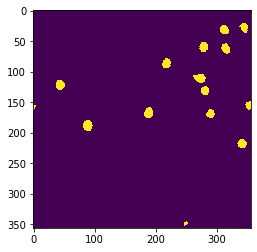

In [ ]:
plt.imshow(preds[1][2][...,1]>0.5)

In [ ]:
preds[1][2][...,1].max()

0.99999917

In [ ]:
train_generator[0][1]['softmax'][0,...,1].shape

(356, 356)

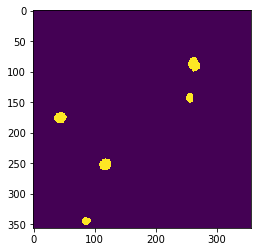

In [ ]:
plt.imshow(train_generator[0][1]['softmax'][0,...,1]);